# Calculate kmer distribution for all sequences in UniProt
Can be used downstream as a potential marker for randomness

In [1]:
import re
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from tqdm.auto import tqdm
from pqdm.threads import pqdm

In [21]:
def count_kmers_for_sequence(counter: Counter, seq: str, k: int):
    n_kmers = len(seq) - k + 1
    for i in range(n_kmers):
        kmer = seq[i:i + k]
        counter[kmer] += 1


def load_kmer_counts_for_file(fasta_file: str, result_file: str, k=6):
    kmer_counts = Counter()
    with open(fasta_file) as f:
        _seq_parts = list()
        for line in f:
            if line.startswith('>'):
                if len(_seq_parts) > 0:
                    count_kmers_for_sequence(kmer_counts, ''.join(_seq_parts), k)
                _seq_parts.clear()
                continue
            _seq_parts.append(line.rstrip())
        count_kmers_for_sequence(kmer_counts, ''.join(_seq_parts), k)

    df = pd.DataFrame(data=kmer_counts.most_common(n=1000), columns=['kmer', 'count'])
    df.to_csv(result_file, index=False)

In [26]:
tic = time.perf_counter()
load_kmer_counts_for_file('../data/sprot/uniprot_sprot.fasta', result_file='../data/sprot/kmer_counts.csv')
toc = time.perf_counter()
print(f"Processed the sequences in {toc - tic:0.4f} seconds")

1min 33s ± 2.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Processed the sequences in 87.8458 seconds


In [2]:
df_counts = pd.read_csv('../data/uniprot/trembl_kmer_counts.csv', index_col=None).sort_values('count', ascending=False)
df_counts = df_counts[df_counts['kmer'] != 'XXXXXX']

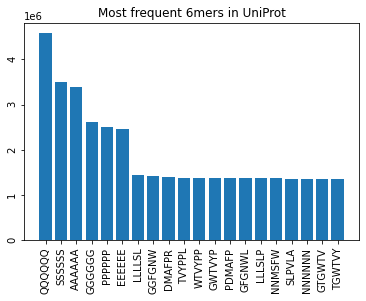

In [25]:
nkmers = 20
fig, ax = plt.subplots()
ax.bar(df_counts['kmer'][:nkmers], df_counts['count'][:nkmers])
ax.set_title(f'Most frequent 6mers in UniProt')
ax.tick_params(labelrotation=90)
plt.show()

In [3]:
def check_repeat(kmer: str, min_len=5):
    return any(all(c == kmer[start] for c in kmer[start + 1:start + min_len]) for start in range(len(kmer) - min_len))


most_freq_kmers = df_counts['kmer'][:2000].values
repeats = []
non_repeats = []
for kmer in most_freq_kmers:
    if check_repeat(kmer):
        repeats.append(kmer)
    else:
        non_repeats.append(kmer)

In [4]:
len(repeats), len(non_repeats)

(68, 1932)

In [5]:
repeat_regex = '|'.join(repeats)
non_repeat_regex = '|'.join(non_repeats)

In [6]:
full_seq = """>tr|E9PWP7|E9PWP7_MOUSE Mucin 3, intestinal OS=Mus musculus OX=10090 GN=Muc3 PE=1 SV=4
MSTRRWVRQTAALCLLAFILHSLPRHIAAENGTTESGSVWDGGGNSTQDDSQETQFRTVLKTKTTDGENSEAWPRQEYQQRSSSPSTTKAEVTTTADVTTTADVTTTAEITTTSDVTTTA
EITNTDDVTTTGEVTTTADVTTTSDVPTTSEVTSTDDVITTAEVTTTAEMTPTDDVTTTSEVTTTGDVTTTGDVTITGDLTTTADVTTKADFTTTDDVTTTADGSTTADLTTTAKVTTTD
DVTTTGEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTIAEITTTDIVTTTGEVTTTA
DVTTTSDVTTTSEETTTADITTTADLTTTAEITTTDDVTTTVEITTTSDVTTTTEITTTDIVTTTGEVTTTADVTTASDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTA
DVTTTSDVTTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTADVTTTSDVPTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTADVTTTSDVTTTTEENPTADITTTA
DLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTDEDTTTADVTTTSDVTTTSEETPTADITTTADLTTTADVTTTSDVTTTSEETTTADVTTTSDVTTTAEITTTD
DITSTADVTTTTNVTTTSDVPTTSEVTSTDDVITTTEVTTTAEIIPTDDVTTTSEVTTTGDVTTTGDVTMTGDLTTTADVTTTADLTTTDEVTTTADGSTTADLTTTAEVTTTDDVTTTV
QITTTSEITTTSDVTTTAEITTTDNVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLNTTAEVTTTEDVTTTVEITTTSEITTTSDITTTAEITTTDIVTTTGEVTTTADVTTTN
DVTTTSEETPTADITTTADLTTTAEITTTDDITSTADVTTTTDVTTTSDVPTTSEVTSTDDVITTTEVTTTAEIIPTDDVTTTSEVTTTGDVTTTGDVTMTGDLTTTADVTTTADLTTTD
EVTTTADGSTTADLTTTAEVTTTDDVTTTVQITTTSEITTTSDVTTTAEITTTDNVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTEDVTTTVEITTTSEITTTS
DITTTAEITTTDIVTTTGEVTTTADVTTTNDVTTTSEETPTADITTTADLTTTAEITTTDDVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEITTTDDVTTTGEVTTTA
DVTTTSDITTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDITTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTG
EVTTTADVTTTSDVTTTSEQTPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADITTTSDVTTTSEETTTADVTTTTDVTTTSEETTTG
DGKTTTAEITTTDDITTTADVTTTPDVTTTAAVTTTGEITPTDDVTTTSEVTTTGDVTSTGDVTTTGEVTTTAEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTT
GEVTTTADVTTTSDTTTTSEETPTADITTTVDLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTSDIFTTTGEVTTTADITTTSDVTTTSEETPTADITTTADLTTTAEITTT
DDVTTTVEITTTSEITTTSEVTTTPDVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTVDVTTTNDVTTTSEETPT
ADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDITTTSEETPTADITTTVDLTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTT
ADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTSGEVTTTADVTTTSDVTTTSEETTTADVTTTTDVTTTSEETTTGDGTTTTAEITTTDDLTTTADVTTTPDVTT
TAAVTTTAEITPTDDVTTTSEVTTTGDVTTTGEVTTTAEVTTTDDVTTTGDVTTTGDLTTMADVTTTADFTTTDDVTTTADASTTADLATTAEVTTTDDVTTTVEITTTAEITTTAEVTT
TDDVTTTGEVTTTADVTTTTDVTTTSEVTTTADVTTTNDVTTTAEITTTDDITTTADVTTTADVTTTSYVPTTSEVTSTDDVTTTAEVTTTAEITPTDDVTTTSEVTTTGDVTTTGDVTM
TCDLTTSADVTTTADFTTTDDVTTKADGSTTADLTTTAEVTTNDDVTTTGELTTTAEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETTTADITTTADLTTTAEVTT
TDDVTTTVEITTTSEITTTSDVTTIAEITTTDIVTTTGEVTTTADVTTTNDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTT
TAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADITTTSDVTTTSEETTTADVTTTTDVTTTSEETTTGDGKTTTAEITTTDDITTTADVTTTPDVTTTAAVT
TTGEITPTDDVTTTSEVTTTGDVTTTGDVTTTGEVTTTAEVTTTDDVTTTGDVTTTGDLTTTADVTTTAYFTTTDDVTTTADGSTTADLTTTAEVTTTDDVTTTVEITTTAEITTTDDVT
TTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVT
TTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTAEITTTDDVTTTGEVTTTADVTTTAEVI
TTSDVTTTADVTTMPDFTTTAEVTTTLDVTTNDEVTTTSVVTTTPEITTAGDVTTTSEVTTSADLTTTPEITTTGDVTTTADVTTTADITTTSDVTTTADVTTTADITTTSDVTTTADVT
TIADLSTTPEITTTGDFSSTTDVTSTGDVTTTADVTTTADVTTTGDVTTTAEVTTTAEVTTTAEATTTADLNTTPEITTTDDVTTTGDVTITAEVTTTAYVTTTTDFTTTAEVNTTDDVT
TIADLTTTAEVTTTNDVTSTAEITTTADLTTTTEVTTTADFITTGDVTTTADVTTMADVTTTADVTTADLTTTVDVTTMDDVTTTAEVITSGDVTTTSEVTTTSNLNTTPEITTTIDFTS
TVDVTTTGDVTTTADVTTTSDVTTTSKVTTTGDVTTTADTTSTADVTTTADVITTAEVTTTADFTNTGDVTTSADVTTTADLTTMPDLTTTAEVTTTADVTTTSEFTTTADVTTTADVTS
TADVTTTAEVTTTGDVTTTADVTNTGDITTIGDVTTTTEITTTAYLTTTLEITTTGEVTSTADVTTSAEVTTTDEITTTDVVTTTGDVTPTAESTTTDDVTTTSDVTTTGDFTTTADVTT
TAYVTTTPDVTTTVEVTTTADFTTTGVVNTTADVTTTADVTTTSEVTTTADLTTTPEITTTVDFTSTADVTTTADVITTPEVTTTSDVTTTAEVITTADVTTTADVTTTVEVTTTGDVTI
TADVTTTPEITTTVDFTSTADVTITADVTTTADVTTTSDVTITPDVTTTAEVTTTVEITTTDDVTTTGEVTTTADVTTTSDVTTTSEETTTADITTTSDVSTTSEVTTTAYVTTTADTTS
TAEVTTTADVTTTADVTTTADVTTTADVTTTVEVTTTGDVTTTADVTTTAEVTTTAEITTTGDVTTTADVTTTAEVTTTAEITTTGDVTTTADVTTTADVTTTADVTTTIDVTTTADVTT
SAEVTTTADVTTTTEVTTTTEVATTPEPTTTPAPTTTAVNCMNGGFWTGDKCICPNGFGGDRCENIVNVVNCENGGTWDGLKCQCTSLFYGPRCEELVESVEIEPTVAASVEVSVTVTSQ
EYSEKLQDRKSEEFSNFNKTFTKQMALIYAGIPEYEGVIIKNLSKGSIVVDYDVILKAKYTPGFENTLDTVVKNLETKIKNATEVQVQDVNNNCSALLCFNSTATKVQNSATVSVNPEET
CKKEAGEDFAKFVTLGQKGDKWFCITPCSAGYSTSKNCSYGKCQLQRSGPQCLCLITDTHWYSGENCDWGIQKSLVYGLGGAGVAVLLVILVILLVFSIRFRKDAQRQRSRVSEMYKWGE
EEGRASPGTFHNFGFDHNEERENYMPLDSVYNTFQPSLNHINPERKIQIQRPQVVMTSL"""
seq = ''
for _line in full_seq.split('\n'):
    if _line.startswith(">"):
        continue
    seq += _line.strip()

In [7]:
def count_6mers_counter(seq: str, k=6):
    counter = Counter()
    n_kmers = len(seq) - k + 1
    for i in range(n_kmers):
        kmer = seq[i:i + k]
        counter[kmer] += 1
    return sum([counter[repeat] for repeat in repeats]), sum([counter[non_repeat] for non_repeat in non_repeats])


def count_6mers_regex(seq: str):
    return sum(1 for _ in re.finditer(f'(?=({repeat_regex}))', seq)), sum(
        1 for _ in re.finditer(f'(?=({non_repeat_regex}))', seq))

In [8]:
%%timeit
count_6mers_counter(seq)

1.02 ms ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
%%timeit
count_6mers_regex(seq)

26 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Plot kmer frequency

In [2]:
import glob
import matplotlib.pyplot as plt

In [17]:
dfs = []
for proteome_file in glob.glob('../data/alphafold/v2/AA_scores/*.csv'):
    proteome = re.search(r"/([A-Z0-9]+).csv", proteome_file).group(1)
    proteome_df = pd.read_csv(proteome_file, index_col=0)
    proteome_df['proteome'] = proteome
    dfs.append(proteome_df)
df = pd.concat(dfs)

In [18]:
df.describe()

,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000
count,545555.000000,545555.00000,542051.000000,545555.000000,545555.000000,545555.000000,545555.000000,522125.000000,514622.000000,514622.000000,514622.000000,514622.000000,513491.000000,514622.000000,514622.000000
mean,458.873356,1.11808,30.845778,33.727809,75.312362,79.094267,0.354822,125.969805,0.515753,0.000657,0.583850,0.019857,-0.311983,0.755625,0.976791
std,880.781186,12.27124,1.455963,11.363737,14.949144,18.772187,0.291004,147.224706,4.485592,0.048485,4.739796,0.394819,0.317159,5.020129,3.640865
min,16.000000,0.00000,6.000000,1.390000,23.077300,22.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.987435,0.000000,0.000000
25%,186.000000,0.00000,30.900000,25.620000,64.928350,64.540000,0.112200,38.063900,0.000000,0.000000,0.000000,0.000000,-0.564031,0.000000,0.000000
50%,333.000000,0.00000,31.300000,31.180000,77.976200,87.315000,0.272000,80.049100,0.000000,0.000000,0.000000,0.000000,-0.345583,0.000000,0.000000
75%,538.000000,1.00000,31.400000,38.590000,87.562600,93.995000,0.552100,156.520200,0.000000,0.000000,0.000000,0.000000,-0.103957,0.000000,1.000000
max,32200.000000,285.00000,31.700000,97.030000,98.724100,98.860000,1.000000,2730.699900,342.000000,11.000000,382.000000,83.000000,0.918797,386.000000,673.000000


In [19]:
df['repeat_6mers'] = df['repeat_6mers_2000']
df['non_repeat_6mers'] = df['non_repeat_6mers_2000']

In [20]:
df = df[df['repeat_6mers'].notnull()]
df = df[df['non_repeat_6mers'].notnull()]
df['repeat_6mers_normalized'] = df['repeat_6mers'] / df['seq_len']
df['non_repeat_6mers_normalized'] = df['non_repeat_6mers'] / df['seq_len']

In [21]:
df[['repeat_6mers', 'non_repeat_6mers', 'repeat_6mers_normalized', 'non_repeat_6mers_normalized']].describe()

,repeat_6mers,non_repeat_6mers,repeat_6mers_normalized,non_repeat_6mers_normalized
count,514622.000000,514622.000000,514622.000000,514622.000000
mean,0.755625,0.976791,0.001580,0.002406
std,5.020129,3.640865,0.009674,0.008889
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.001862
max,386.000000,673.000000,0.807487,0.771930


In [22]:
df.nlargest(n=5, columns='repeat_6mers_normalized')

,uniprot_id,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,proteome,repeat_6mers_normalized,non_repeat_6mers_normalized
700,Q75JC9,374,0.0,30.6,34.25,47.5191,42.780,0.9332,128.0841,302.0,1.0,301.0,0.0,0.160335,302.0,1.0,DICDI,0.807487,0.002674
7896,A0A5S6PEZ3,212,0.0,31.0,34.91,50.0730,45.700,0.8679,81.5734,169.0,2.0,168.0,0.0,0.582109,169.0,2.0,BRUMA,0.797170,0.009434
19179,F1LZG1,136,0.0,27.5,83.22,97.7315,98.105,0.0000,42.7958,103.0,0.0,95.0,0.0,-0.276223,103.0,0.0,RAT,0.757353,0.000000
4162,A0A2R8Q8C4,208,0.0,31.0,44.88,57.4058,55.360,0.9087,197.1297,155.0,3.0,155.0,0.0,-0.048053,155.0,3.0,DANRE,0.745192,0.014423
425,F1M0N4,50,0.0,23.4,84.03,92.5000,93.400,0.0000,49.8549,37.0,1.0,36.0,0.0,0.420325,37.0,1.0,RAT,0.740000,0.020000


In [23]:
df.nlargest(n=5, columns='non_repeat_6mers_normalized')

,uniprot_id,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,proteome,repeat_6mers_normalized,non_repeat_6mers_normalized
20045,A0A0G2JYP7,57,0.0,23.7,83.04,95.7279,96.530,0.0000,18.5751,0.0,44.0,0.0,0.0,0.010458,0.0,44.0,RAT,0.000000,0.771930
13926,A0A0G2KB14,58,0.0,25.1,73.28,91.7364,92.575,0.0000,17.8091,0.0,44.0,0.0,0.0,0.322827,0.0,44.0,RAT,0.000000,0.758621
824,A0A2R8QGX2,273,0.0,31.2,31.23,73.0712,83.150,0.2747,0.2751,0.0,203.0,0.0,0.0,-0.709486,0.0,203.0,DANRE,0.000000,0.743590
2639,A0A0G2K1C3,57,0.0,22.6,79.39,95.5974,95.980,0.0000,19.0790,2.0,42.0,2.0,0.0,-0.321057,2.0,42.0,RAT,0.035088,0.736842
17903,A0A0G2K7C0,57,0.0,28.0,52.60,93.9181,96.730,0.0526,19.1597,2.0,41.0,2.0,0.0,-0.213012,2.0,41.0,RAT,0.035088,0.719298


In [24]:
%matplotlib notebook
fig = plt.figure()

ax = plt.axes(projection='3d')
p = ax.scatter(df['ratio_bad_plddt'], df['median_plddt'], df['mean_plddt'], c=df['repeat_6mers_normalized'],
               cmap='viridis')
ax.set_xlabel("Ratio bad pLDDT")
ax.set_ylabel("Median pLDDT")
ax.set_zlabel("Mean pLDDT")
fig.colorbar(p, ax=ax)
plt.show()

<IPython.core.display.Javascript object>

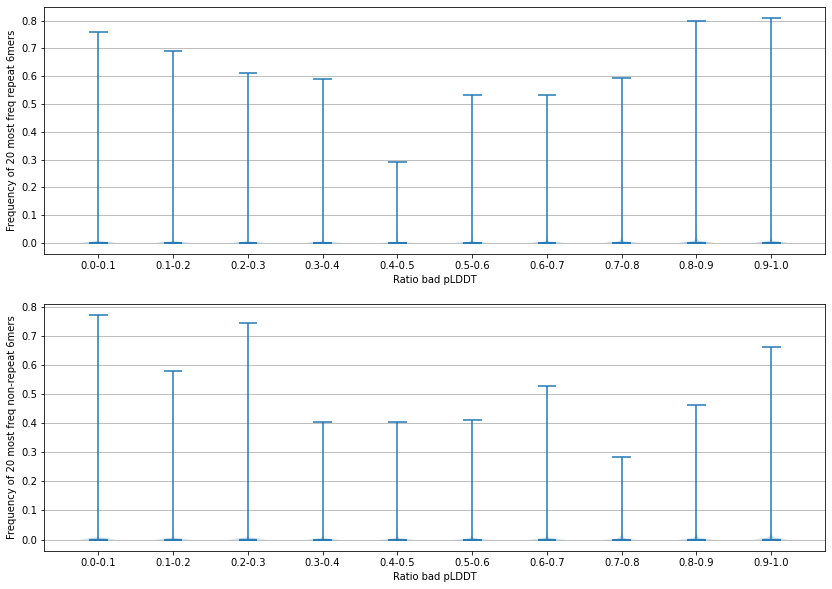

In [10]:
%matplotlib inline
fig, [ax1, ax2] = plt.subplots(nrows=2, figsize=(14, 10))


def violin_plot(ax, split_prop, show_prop, ylabel, bucket_step_size, decimals=0):
    buckets_indices = np.arange(np.floor(df[split_prop].min()), df[split_prop].max(), bucket_step_size)
    buckets = [df[df[split_prop].between(i, i + bucket_step_size, inclusive='left')] for i in buckets_indices]
    labels = [f'{np.round(i, decimals=decimals)}-{np.round(i + bucket_step_size, decimals=decimals)}' for i in
              buckets_indices]
    ax.violinplot(dataset=[bucket[show_prop].values for bucket in buckets], showmedians=True)
    ax.yaxis.grid(True)
    ax.set_xlabel('Ratio bad pLDDT')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)


violin_plot(ax1, 'ratio_bad_plddt', 'repeat_6mers_normalized', 'Frequency of 20 most freq repeat 6mers', 0.1, decimals=1)
violin_plot(ax2, 'ratio_bad_plddt', 'non_repeat_6mers_normalized', 'Frequency of 20 most freq non-repeat 6mers', 0.1, decimals=1)

plt.show()

In [11]:
from scipy.stats import spearmanr

rho, p = spearmanr(df['ratio_bad_plddt'], df['repeat_6mers_normalized'])
print(f'Spearman rank correlation (Repeat): {"{0:.4f}".format(rho)}')
rho2, p2 = spearmanr(df['ratio_bad_plddt'], df['non_repeat_6mers_normalized'])
print(f'Spearman rank correlation (Non-repeat): {"{0:.4f}".format(rho2)}')

Spearman rank correlation (Repeat): 0.2417
Spearman rank correlation (Non-repeat): 0.1342


In [12]:
# Looks like there might be some correlation for repeat 6mers that changes at around 0.5
df_good_ratio = df[df['ratio_bad_plddt'] < 0.5]
df_bad_ratio = df[df['ratio_bad_plddt'] >= 0.5]

In [13]:
rho_good, _ = spearmanr(df_good_ratio['ratio_bad_plddt'], df_good_ratio['repeat_6mers_normalized'])
rho_bad, _ = spearmanr(df_bad_ratio['ratio_bad_plddt'], df_bad_ratio['repeat_6mers_normalized'])
print(f'Spearman rank correlation (Good, repeat): {"{0:.4f}".format(rho_good)}')
print(f'Spearman rank correlation (Bad, repeat): {"{0:.4f}".format(rho_bad)}')

Spearman rank correlation (Good, repeat): 0.2145
Spearman rank correlation (Bad, repeat): -0.0671


In [14]:
df[df['uniprot_id'] == 'E9PWP7']

,uniprot_id,seq_len,domain_count,max_pae,min_plddt,mean_plddt,median_plddt,ratio_bad_plddt,iupred_auc,repeat_6mers,non_repeat_6mers,repeat_6mers_100,non_repeat_6mers_100,iupred_plddt_spearman,repeat_6mers_2000,non_repeat_6mers_2000,proteome,repeat_6mers_normalized,non_repeat_6mers_normalized
20522,E9PWP7,378,1.0,31.4,40.86,84.6046,89.955,0.1534,2730.6999,0.0,0.0,0.0,0.0,-0.14276,0.0,0.0,MOUSE,0.0,0.0


### Outlier: Going from kmer to motif
We did find sequences where IUPRED predicts very high disorder but no kmers were found. We might have to extend to motifs using [MAST](https://meme-suite.org/).

`T(\s)?(T|S)(\s)?(T|I)`

In [34]:
full_seq = """>tr|E9PWP7|E9PWP7_MOUSE Mucin 3, intestinal OS=Mus musculus OX=10090 GN=Muc3 PE=1 SV=4
MSTRRWVRQTAALCLLAFILHSLPRHIAAENGTTESGSVWDGGGNSTQDDSQETQFRTVLKTKTTDGENSEAWPRQEYQQRSSSPSTTKAEVTTTADVTTTADVTTTAEITTTSDVTTTA
EITNTDDVTTTGEVTTTADVTTTSDVPTTSEVTSTDDVITTAEVTTTAEMTPTDDVTTTSEVTTTGDVTTTGDVTITGDLTTTADVTTKADFTTTDDVTTTADGSTTADLTTTAKVTTTD
DVTTTGEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTIAEITTTDIVTTTGEVTTTA
DVTTTSDVTTTSEETTTADITTTADLTTTAEITTTDDVTTTVEITTTSDVTTTTEITTTDIVTTTGEVTTTADVTTASDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTA
DVTTTSDVTTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTADVTTTSDVPTTSEETTTADVTTTSDVTTTAEITTTDDITSTADVTTTADVTTTSDVTTTTEENPTADITTTA
DLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTDEDTTTADVTTTSDVTTTSEETPTADITTTADLTTTADVTTTSDVTTTSEETTTADVTTTSDVTTTAEITTTD
DITSTADVTTTTNVTTTSDVPTTSEVTSTDDVITTTEVTTTAEIIPTDDVTTTSEVTTTGDVTTTGDVTMTGDLTTTADVTTTADLTTTDEVTTTADGSTTADLTTTAEVTTTDDVTTTV
QITTTSEITTTSDVTTTAEITTTDNVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLNTTAEVTTTEDVTTTVEITTTSEITTTSDITTTAEITTTDIVTTTGEVTTTADVTTTN
DVTTTSEETPTADITTTADLTTTAEITTTDDITSTADVTTTTDVTTTSDVPTTSEVTSTDDVITTTEVTTTAEIIPTDDVTTTSEVTTTGDVTTTGDVTMTGDLTTTADVTTTADLTTTD
EVTTTADGSTTADLTTTAEVTTTDDVTTTVQITTTSEITTTSDVTTTAEITTTDNVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTEDVTTTVEITTTSEITTTS
DITTTAEITTTDIVTTTGEVTTTADVTTTNDVTTTSEETPTADITTTADLTTTAEITTTDDVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEITTTDDVTTTGEVTTTA
DVTTTSDITTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDITTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTG
EVTTTADVTTTSDVTTTSEQTPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADITTTSDVTTTSEETTTADVTTTTDVTTTSEETTTG
DGKTTTAEITTTDDITTTADVTTTPDVTTTAAVTTTGEITPTDDVTTTSEVTTTGDVTSTGDVTTTGEVTTTAEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTT
GEVTTTADVTTTSDTTTTSEETPTADITTTVDLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTSDIFTTTGEVTTTADITTTSDVTTTSEETPTADITTTADLTTTAEITTT
DDVTTTVEITTTSEITTTSEVTTTPDVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTVDVTTTNDVTTTSEETPT
ADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDITTTSEETPTADITTTVDLTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTT
ADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTSGEVTTTADVTTTSDVTTTSEETTTADVTTTTDVTTTSEETTTGDGTTTTAEITTTDDLTTTADVTTTPDVTT
TAAVTTTAEITPTDDVTTTSEVTTTGDVTTTGEVTTTAEVTTTDDVTTTGDVTTTGDLTTMADVTTTADFTTTDDVTTTADASTTADLATTAEVTTTDDVTTTVEITTTAEITTTAEVTT
TDDVTTTGEVTTTADVTTTTDVTTTSEVTTTADVTTTNDVTTTAEITTTDDITTTADVTTTADVTTTSYVPTTSEVTSTDDVTTTAEVTTTAEITPTDDVTTTSEVTTTGDVTTTGDVTM
TCDLTTSADVTTTADFTTTDDVTTKADGSTTADLTTTAEVTTNDDVTTTGELTTTAEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETTTADITTTADLTTTAEVTT
TDDVTTTVEITTTSEITTTSDVTTIAEITTTDIVTTTGEVTTTADVTTTNDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTT
TAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADITTTSDVTTTSEETTTADVTTTTDVTTTSEETTTGDGKTTTAEITTTDDITTTADVTTTPDVTTTAAVT
TTGEITPTDDVTTTSEVTTTGDVTTTGDVTTTGEVTTTAEVTTTDDVTTTGDVTTTGDLTTTADVTTTAYFTTTDDVTTTADGSTTADLTTTAEVTTTDDVTTTVEITTTAEITTTDDVT
TTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVT
TTDDVTTTVEITTTSEITTTSDVTTTAEITTTDIVTTTGEVTTTADVTTTSDVTTTSEETPTADITTTADLTTTAEVTTTDDVTTTVEITTTAEITTTDDVTTTGEVTTTADVTTTAEVI
TTSDVTTTADVTTMPDFTTTAEVTTTLDVTTNDEVTTTSVVTTTPEITTAGDVTTTSEVTTSADLTTTPEITTTGDVTTTADVTTTADITTTSDVTTTADVTTTADITTTSDVTTTADVT
TIADLSTTPEITTTGDFSSTTDVTSTGDVTTTADVTTTADVTTTGDVTTTAEVTTTAEVTTTAEATTTADLNTTPEITTTDDVTTTGDVTITAEVTTTAYVTTTTDFTTTAEVNTTDDVT
TIADLTTTAEVTTTNDVTSTAEITTTADLTTTTEVTTTADFITTGDVTTTADVTTMADVTTTADVTTADLTTTVDVTTMDDVTTTAEVITSGDVTTTSEVTTTSNLNTTPEITTTIDFTS
TVDVTTTGDVTTTADVTTTSDVTTTSKVTTTGDVTTTADTTSTADVTTTADVITTAEVTTTADFTNTGDVTTSADVTTTADLTTMPDLTTTAEVTTTADVTTTSEFTTTADVTTTADVTS
TADVTTTAEVTTTGDVTTTADVTNTGDITTIGDVTTTTEITTTAYLTTTLEITTTGEVTSTADVTTSAEVTTTDEITTTDVVTTTGDVTPTAESTTTDDVTTTSDVTTTGDFTTTADVTT
TAYVTTTPDVTTTVEVTTTADFTTTGVVNTTADVTTTADVTTTSEVTTTADLTTTPEITTTVDFTSTADVTTTADVITTPEVTTTSDVTTTAEVITTADVTTTADVTTTVEVTTTGDVTI
TADVTTTPEITTTVDFTSTADVTITADVTTTADVTTTSDVTITPDVTTTAEVTTTVEITTTDDVTTTGEVTTTADVTTTSDVTTTSEETTTADITTTSDVSTTSEVTTTAYVTTTADTTS
TAEVTTTADVTTTADVTTTADVTTTADVTTTVEVTTTGDVTTTADVTTTAEVTTTAEITTTGDVTTTADVTTTAEVTTTAEITTTGDVTTTADVTTTADVTTTADVTTTIDVTTTADVTT
SAEVTTTADVTTTTEVTTTTEVATTPEPTTTPAPTTTAVNCMNGGFWTGDKCICPNGFGGDRCENIVNVVNCENGGTWDGLKCQCTSLFYGPRCEELVESVEIEPTVAASVEVSVTVTSQ
EYSEKLQDRKSEEFSNFNKTFTKQMALIYAGIPEYEGVIIKNLSKGSIVVDYDVILKAKYTPGFENTLDTVVKNLETKIKNATEVQVQDVNNNCSALLCFNSTATKVQNSATVSVNPEET
CKKEAGEDFAKFVTLGQKGDKWFCITPCSAGYSTSKNCSYGKCQLQRSGPQCLCLITDTHWYSGENCDWGIQKSLVYGLGGAGVAVLLVILVILLVFSIRFRKDAQRQRSRVSEMYKWGE
EEGRASPGTFHNFGFDHNEERENYMPLDSVYNTFQPSLNHINPERKIQIQRPQVVMTSL"""
seq = ''
for _line in full_seq.split('\n'):
    if _line.startswith(">"):
        continue
    seq += _line.strip()